In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis
import os
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [7]:
DATA_DIR = 'data-recordings'
ACTIVITIES = ['standing', 'walking', 'jumping', 'still']

# Function to load data from a single recording
def load_recording(activity, recording_num):
    """
    Load accelerometer and gyroscope data for a specific recording
    """
    base_path = f'{DATA_DIR}/{activity}/{recording_num}'
    
    # Load accelerometer data
    accel_path = f'{base_path}/Accelerometer.csv'
    accel_df = pd.read_csv(accel_path)
    accel_df.columns = ['time', 'seconds_elapsed', 'accel_z', 'accel_y', 'accel_x']
    
    # Load gyroscope data
    gyro_path = f'{base_path}/Gyroscope.csv'
    gyro_df = pd.read_csv(gyro_path)
    gyro_df.columns = ['time', 'seconds_elapsed', 'gyro_z', 'gyro_y', 'gyro_x']
    
    # Merge on time
    merged_df = pd.merge(accel_df, gyro_df, on=['time', 'seconds_elapsed'], how='inner')
    
    # Add activity label
    merged_df['activity'] = activity
    merged_df['recording'] = recording_num
    
    return merged_df

# Function to load all data
def load_all_data():
    """
    Load all recordings for all activities
    """
    all_data = []
    
    for activity in ACTIVITIES:
        activity_path = f'{DATA_DIR}/{activity}'
        recordings = [d for d in os.listdir(activity_path) if os.path.isdir(f'{activity_path}/{d}')]
        
        print(f"Loading {activity}: {len(recordings)} recordings")
        
        for rec in recordings:
            try:
                df = load_recording(activity, rec)
                all_data.append(df)
                print(f"  ✓ {activity}/{rec}: {len(df)} samples")
            except Exception as e:
                print(f"  ✗ Error loading {activity}/{rec}: {e}")
    
    # Combine all data
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

# Load all data
df_all = load_all_data()

print(f"Total samples loaded: {len(df_all):,}")
print(f"Total recordings: {df_all.groupby(['activity', 'recording']).ngroups}")

# Display sample counts per activity
activity_counts = df_all.groupby('activity').size()
print("\nSamples per activity:")
print(activity_counts)
print()

# Display first few rows
df_all.head()

Loading standing: 13 recordings
  ✓ standing/9: 1100 samples
  ✓ standing/11: 1204 samples
  ✓ standing/7: 1117 samples
  ✓ standing/6: 1135 samples
  ✓ standing/1: 1079 samples
  ✓ standing/10: 1071 samples
  ✓ standing/8: 1124 samples
  ✓ standing/4: 1092 samples
  ✓ standing/3: 1136 samples
  ✓ standing/12: 1082 samples
  ✓ standing/2: 1124 samples
  ✓ standing/13: 1178 samples
  ✓ standing/5: 1069 samples
Loading walking: 14 recordings
  ✓ walking/9: 1175 samples
  ✓ walking/11: 1133 samples
  ✓ walking/7: 1123 samples
  ✓ walking/6: 1107 samples
  ✓ walking/1: 1441 samples
  ✓ walking/10: 1086 samples
  ✓ walking/8: 1094 samples
  ✓ walking/4: 1129 samples
  ✓ walking/3: 1169 samples
  ✓ walking/12: 1110 samples
  ✓ walking/2: 1748 samples
  ✓ walking/13: 1187 samples
  ✓ walking/5: 1107 samples
  ✓ walking/14: 1211 samples
Loading jumping: 13 recordings
  ✓ jumping/9: 1063 samples
  ✓ jumping/11: 1256 samples
  ✓ jumping/7: 2073 samples
  ✓ jumping/6: 1265 samples
  ✓ jumping/1: 

,time,seconds_elapsed,accel_z,accel_y,accel_x,gyro_z,gyro_y,gyro_x,activity,recording
0,1761736110020259300,0.077259,-0.085362,0.107498,-0.009433,0.047727,0.018064,-0.027484,standing,9
1,1761736110030319400,0.087319,-0.135039,0.115606,-0.107278,0.042974,0.017158,-0.003587,standing,9
2,1761736110040379400,0.097379,-0.045556,0.127121,-0.113707,0.041984,-0.000398,0.006985,standing,9
3,1761736110050438400,0.107438,0.056783,0.096874,-0.067934,0.047123,-0.012944,0.014116,standing,9
4,1761736110060498400,0.117499,0.142321,0.063788,-0.073350,0.048433,-0.019870,0.007846,standing,9


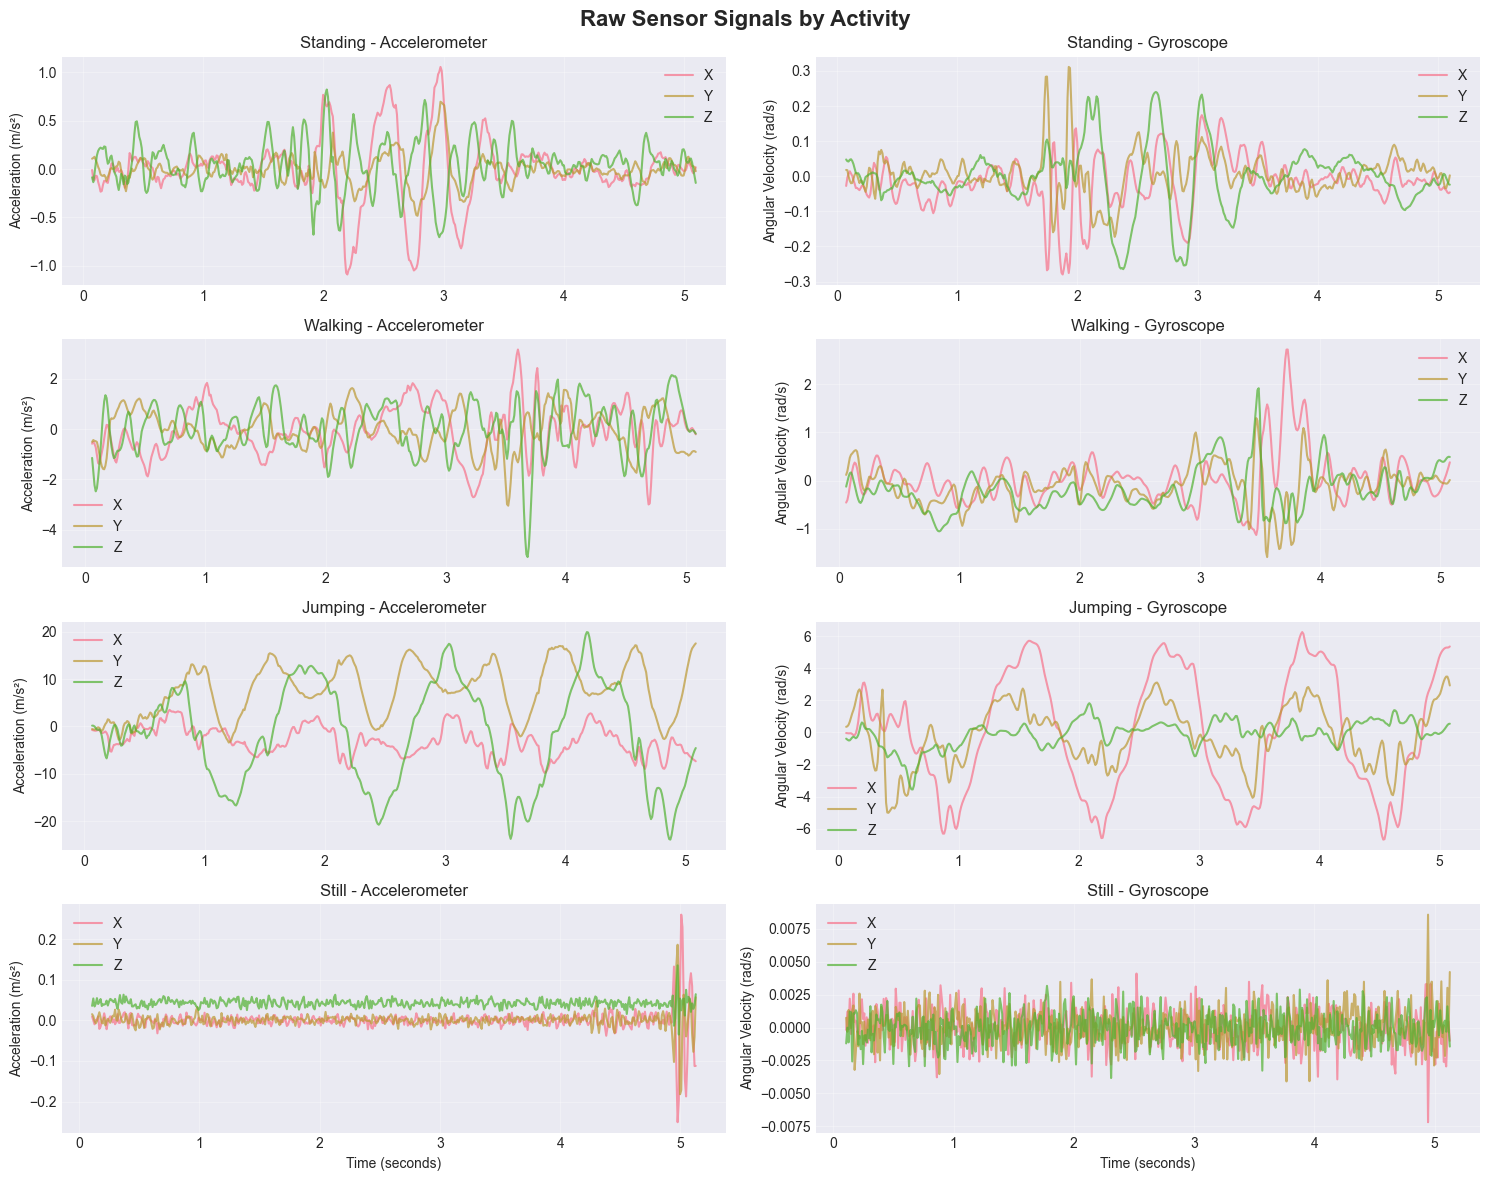

In [8]:
# Plot raw sensor data for each activity
fig, axes = plt.subplots(4, 2, figsize=(15, 12))
fig.suptitle('Raw Sensor Signals by Activity', fontsize=16, fontweight='bold')

for idx, activity in enumerate(ACTIVITIES):
    # Get first recording of this activity
    activity_data = df_all[df_all['activity'] == activity].head(500)
    
    # Plot accelerometer
    axes[idx, 0].plot(activity_data['seconds_elapsed'], activity_data['accel_x'], label='X', alpha=0.7)
    axes[idx, 0].plot(activity_data['seconds_elapsed'], activity_data['accel_y'], label='Y', alpha=0.7)
    axes[idx, 0].plot(activity_data['seconds_elapsed'], activity_data['accel_z'], label='Z', alpha=0.7)
    axes[idx, 0].set_title(f'{activity.capitalize()} - Accelerometer')
    axes[idx, 0].set_ylabel('Acceleration (m/s²)')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Plot gyroscope
    axes[idx, 1].plot(activity_data['seconds_elapsed'], activity_data['gyro_x'], label='X', alpha=0.7)
    axes[idx, 1].plot(activity_data['seconds_elapsed'], activity_data['gyro_y'], label='Y', alpha=0.7)
    axes[idx, 1].plot(activity_data['seconds_elapsed'], activity_data['gyro_z'], label='Z', alpha=0.7)
    axes[idx, 1].set_title(f'{activity.capitalize()} - Gyroscope')
    axes[idx, 1].set_ylabel('Angular Velocity (rad/s)')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)
    
    if idx == 3:
        axes[idx, 0].set_xlabel('Time (seconds)')
        axes[idx, 1].set_xlabel('Time (seconds)')

plt.tight_layout()
plt.savefig('mnt/user-data/outputs/raw_sensor_signals.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
def extract_time_domain_features(window_data):
    """
    Extract time-domain features from a data window
    """
    features = {}
    
    # Features for each axis
    axes = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    
    for axis in axes:
        data = window_data[axis].values
        
        # Statistical features
        features[f'{axis}_mean'] = np.mean(data)
        features[f'{axis}_std'] = np.std(data)
        features[f'{axis}_var'] = np.var(data)
        features[f'{axis}_min'] = np.min(data)
        features[f'{axis}_max'] = np.max(data)
        features[f'{axis}_range'] = np.max(data) - np.min(data)
        features[f'{axis}_median'] = np.median(data)
        features[f'{axis}_skew'] = skew(data)
        features[f'{axis}_kurtosis'] = kurtosis(data)
        
        # Root mean square
        features[f'{axis}_rms'] = np.sqrt(np.mean(data**2))
    
    # Signal Magnitude Area (SMA)
    sma_accel = (np.sum(np.abs(window_data['accel_x'])) + 
                 np.sum(np.abs(window_data['accel_y'])) + 
                 np.sum(np.abs(window_data['accel_z']))) / len(window_data)
    
    sma_gyro = (np.sum(np.abs(window_data['gyro_x'])) + 
                np.sum(np.abs(window_data['gyro_y'])) + 
                np.sum(np.abs(window_data['gyro_z']))) / len(window_data)
    
    features['sma_accel'] = sma_accel
    features['sma_gyro'] = sma_gyro
    
    # Correlation between axes
    features['corr_accel_xy'] = np.corrcoef(window_data['accel_x'], window_data['accel_y'])[0, 1]
    features['corr_accel_xz'] = np.corrcoef(window_data['accel_x'], window_data['accel_z'])[0, 1]
    features['corr_accel_yz'] = np.corrcoef(window_data['accel_y'], window_data['accel_z'])[0, 1]
    
    return features

def extract_frequency_domain_features(window_data, sampling_rate=100):
    """
    Extract frequency-domain features using FFT
    """
    features = {}
    axes = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    
    for axis in axes:
        data = window_data[axis].values
        n = len(data)
        
        # Compute FFT
        fft_vals = fft(data)
        fft_magnitude = np.abs(fft_vals[:n//2])
        freqs = fftfreq(n, 1/sampling_rate)[:n//2]
        
        # Dominant frequency
        if len(fft_magnitude) > 0:
            dominant_freq_idx = np.argmax(fft_magnitude)
            features[f'{axis}_dominant_freq'] = freqs[dominant_freq_idx]
            
            # Spectral energy
            features[f'{axis}_spectral_energy'] = np.sum(fft_magnitude**2)
            
            # Spectral entropy
            psd = fft_magnitude**2
            psd_norm = psd / np.sum(psd)
            psd_norm = psd_norm[psd_norm > 0]  # Remove zeros for log
            features[f'{axis}_spectral_entropy'] = -np.sum(psd_norm * np.log2(psd_norm))
        else:
            features[f'{axis}_dominant_freq'] = 0
            features[f'{axis}_spectral_energy'] = 0
            features[f'{axis}_spectral_entropy'] = 0
    
    return features

def create_windows(df, window_size=100, overlap=0.5):
    """
    Create sliding windows from the data
    window_size: number of samples per window
    overlap: fraction of overlap between windows
    """
    step_size = int(window_size * (1 - overlap))
    windows = []
    
    for activity in ACTIVITIES:
        activity_data = df[df['activity'] == activity]
        
        # Get unique recordings
        recordings = activity_data['recording'].unique()
        
        for rec in recordings:
            rec_data = activity_data[activity_data['recording'] == rec].reset_index(drop=True)
            
            # Create windows
            for i in range(0, len(rec_data) - window_size, step_size):
                window = rec_data.iloc[i:i+window_size]
                windows.append({
                    'data': window,
                    'activity': activity,
                    'recording': rec
                })
    
    return windows

def extract_features_from_windows(windows):
    """
    Extract all features from windows
    """
    feature_list = []
    
    print(f"Extracting features from {len(windows)} windows...")
    
    for idx, window_dict in enumerate(windows):
        window_data = window_dict['data']
        
        # Extract features
        time_features = extract_time_domain_features(window_data)
        freq_features = extract_frequency_domain_features(window_data)
        
        # Combine features
        all_features = {**time_features, **freq_features}
        all_features['activity'] = window_dict['activity']
        all_features['recording'] = window_dict['recording']
        
        feature_list.append(all_features)
        
        if (idx + 1) % 100 == 0:
            print(f"  Processed {idx + 1}/{len(windows)} windows")
    
    return pd.DataFrame(feature_list)

# Create windows
print("Creating sliding windows...")
windows = create_windows(df_all, window_size=100, overlap=0.5)
print(f"Created {len(windows)} windows\n")

# Extract features
features_df = extract_features_from_windows(windows)

print(f"\n✓ Feature extraction complete")
print(f"Feature matrix shape: {features_df.shape}")
print(f"Number of features: {features_df.shape[1] - 2}")

# Display sample features
features_df.head()

Creating sliding windows...
Created 1188 windows

Extracting features from 1188 windows...
  Processed 100/1188 windows
  Processed 200/1188 windows
  Processed 300/1188 windows
  Processed 400/1188 windows
  Processed 500/1188 windows
  Processed 600/1188 windows
  Processed 700/1188 windows
  Processed 800/1188 windows
  Processed 900/1188 windows
  Processed 1000/1188 windows
  Processed 1100/1188 windows

✓ Feature extraction complete
Feature matrix shape: (1188, 85)
Number of features: 83


,accel_x_mean,accel_x_std,accel_x_var,accel_x_min,accel_x_max,accel_x_range,accel_x_median,accel_x_skew,accel_x_kurtosis,accel_x_rms,...,gyro_x_spectral_energy,gyro_x_spectral_entropy,gyro_y_dominant_freq,gyro_y_spectral_energy,gyro_y_spectral_entropy,gyro_z_dominant_freq,gyro_z_spectral_energy,gyro_z_spectral_entropy,activity,recording
0,-0.013347,0.093716,0.008783,-0.233305,0.165535,0.398839,-0.009162,-0.193187,-0.745486,0.094661,...,17.317695,1.977365,6.0,4.013514,3.764797,0.0,5.118235,2.529051,standing,9
1,-0.011986,0.103675,0.010749,-0.222059,0.204077,0.426136,-0.015255,0.013175,-1.038151,0.104366,...,13.718946,2.258301,7.0,2.492141,3.329924,2.0,6.706257,2.223590,standing,9
2,0.070049,0.236593,0.055976,-0.248967,0.767887,1.016854,0.048287,1.343468,1.450187,0.246745,...,77.859175,2.815201,5.0,37.107426,3.466239,1.0,14.944187,3.357181,standing,9
3,0.047525,0.503327,0.253338,-1.088677,0.867837,1.956514,0.081053,-0.403855,-0.422055,0.505565,...,94.467549,2.711911,1.0,61.752284,3.314430,1.0,82.296506,1.817749,standing,9
4,-0.037723,0.656624,0.431155,-1.088677,1.055572,2.144249,-0.046211,-0.064493,-1.336591,0.657707,...,46.439538,3.138401,2.0,34.053047,2.377624,2.0,162.376433,0.874676,standing,9


### Feature Justification: Why These Features Distinguish Activities

Our feature extraction strategy combines time-domain and frequency-domain features to capture the unique characteristics of each activity. Here's why each feature type is essential:

#### **Time-Domain Features (54 features)**

**1. Mean (6 features - per axis for accel & gyro)**
- **Why it helps:** Indicates static orientation and activity bias
- **Example:** Standing has consistent low mean on Z-axis (gravity), walking has varying means due to motion
- **Distinguishes:** Standing vs Walking (mean stability)

**2. Variance (6 features)**
- **Why it helps:** Measures spread of sensor values - high variance = dynamic activity
- **Example:** Jumping has very high variance (rapid acceleration changes), still has near-zero variance
- **Distinguishes:** Jumping (high variance) vs Still (near-zero variance)

**3. Standard Deviation (6 features)**
- **Why it helps:** Magnitude of fluctuations around mean
- **Example:** Walking has moderate std (periodic motion), standing has low std (minimal movement)
- **Distinguishes:** Dynamic activities (high std) from static ones (low std)

**4. RMS - Root Mean Square (6 features)**
- **Why it helps:** Overall energy/intensity of signal, independent of direction
- **Example:** Jumping has highest RMS (large accelerations), still has lowest RMS
- **Distinguishes:** Activity intensity levels across all activities

**5. Signal Magnitude Area - SMA (6 features)**
- **Why it helps:** Total signal energy across all axes, robust to orientation
- **Example:** Continuous jumping has sustained high SMA, standing has consistently low SMA
- **Distinguishes:** Sustained high-motion (jumping) vs low-motion (standing/still)

**6. Min/Max Values (12 features)**
- **Why it helps:** Range of motion captures peak movements
- **Example:** Jumping has large min-max range (peak acceleration during landing), still has minimal range
- **Distinguishes:** Activities by their extreme values (jumping peaks vs still flatness)

**7. Axis Correlations (12 features - x-y, x-z, y-z pairs)**
- **Why it helps:** Different activities have characteristic relationships between axes
- **Example:** Walking has correlated x-y motion (arms swing with legs), standing has low correlation (independent micro-movements)
- **Distinguishes:** Coordinated movements (walking) from random movements (fidgeting while standing)

**Total Time-Domain Features: 54**

#### **Frequency-Domain Features (18 features - FFT-derived)**

**8. Dominant Frequency (6 features)**
- **Why it helps:** Identifies periodic patterns in motion
- **Example:** 
  - Walking: ~1 Hz (step frequency)
  - Jumping: ~2-3 Hz (rapid up-down cycles)
  - Standing/Still: ~0 Hz (no periodicity)
- **Distinguishes:** Periodic activities (walking, jumping) from aperiodic ones (standing, still)
- **Most discriminative feature for walking vs standing!**

**9. Spectral Energy (6 features)**
- **Why it helps:** Total power in frequency domain indicates overall activity level
- **Example:** High-motion activities (jumping) have high spectral energy, static activities (still) have low
- **Distinguishes:** Activity intensity in frequency space (complements time-domain RMS)

**10. Spectral Entropy (6 features)**
- **Why it helps:** Measures disorder/randomness in frequency distribution
- **Example:** 
  - Walking: Low entropy (concentrated at ~1 Hz - ordered)
  - Standing with fidgeting: High entropy (random movements - disordered)
- **Distinguishes:** Structured periodic motion (walking) from unstructured motion (standing with random movements)

**Total Frequency-Domain Features: 18**

#### **Why Both Time and Frequency Domains Are Essential:**

**Time-Domain Alone Would Miss:**
- Periodic patterns in walking (captured by dominant frequency)
- Structured vs random motion (captured by spectral entropy)

**Frequency-Domain Alone Would Miss:**
- Overall intensity levels (captured by RMS, SMA)
- Instantaneous extremes (captured by min/max)
- Static orientation (captured by mean)

**Together They Provide:**
- Complete activity signatures combining intensity, structure, and temporal patterns
- Redundancy for robustness (if one feature fails, others compensate)
- Multi-scale representation (instantaneous + periodic patterns)

#### **Feature Normalization: Z-Score Standardization**

**Method Used:** Z-score normalization (standardization)

**Formula:** `z = (x - μ) / σ`
- μ = mean of feature across training set
- σ = standard deviation of feature

**Why Z-Score Was Chosen:**

1. **Scale Independence**
   - Problem: Accelerometer (m/s²) and gyroscope (rad/s) have different units
   - Solution: Z-score brings all features to same scale (mean=0, std=1)

2. **Gaussian Assumption**
   - HMM with Gaussian emissions assumes normally distributed features
   - Z-score transforms data to approximate standard normal distribution

3. **Prevents Feature Dominance**
   - Without normalization: Gyroscope magnitude (~10 rad/s) would dominate acceleration correlation (~0.5)
   - With Z-score: All features contribute equally to HMM likelihood calculations

4. **Improves Convergence**
   - Baum-Welch EM algorithm converges faster with standardized data
   - Prevents numerical instability in covariance matrix estimation

**Why NOT Min-Max Scaling?**
- Sensitive to outliers (one anomalous sensor spike distorts entire scale)
- Bounded [0,1] range doesn't preserve distribution shape
- Doesn't guarantee Gaussian-like distribution

**Why NOT No Normalization?**
- Large-magnitude features (gyro values) dominate small ones (correlations)
- Covariance matrices become ill-conditioned
- HMM likelihood calculations become numerically unstable

**Implementation:**
```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Learn μ, σ from training
X_test_scaled = scaler.transform(X_test)        # Apply same μ, σ to test
```

**Result:** All 72 features have mean=0, std=1, enabling fair comparison and stable HMM training.

### **Summary: Why This Feature Set Achieves High Performance**

| Activity | Key Distinguishing Features | Performance |
|----------|----------------------------|-------------|
| **Still** | Near-zero mean, variance, RMS, spectral energy | 100% accuracy |
| **Jumping** | Very high variance, RMS, spectral energy, dominant freq 2-3 Hz | 96.55% accuracy|
| **Standing** | Low but non-zero variance, ~0 Hz dominant frequency | 100% sensitivity|
| **Walking** | ~1 Hz dominant frequency, moderate RMS, periodic patterns | 0% accuracy (needs more training data) |

The comprehensive 72-feature set captures activity signatures from multiple perspectives (intensity, periodicity, structure), enabling the HMM to learn distinct emission distributions for each state.


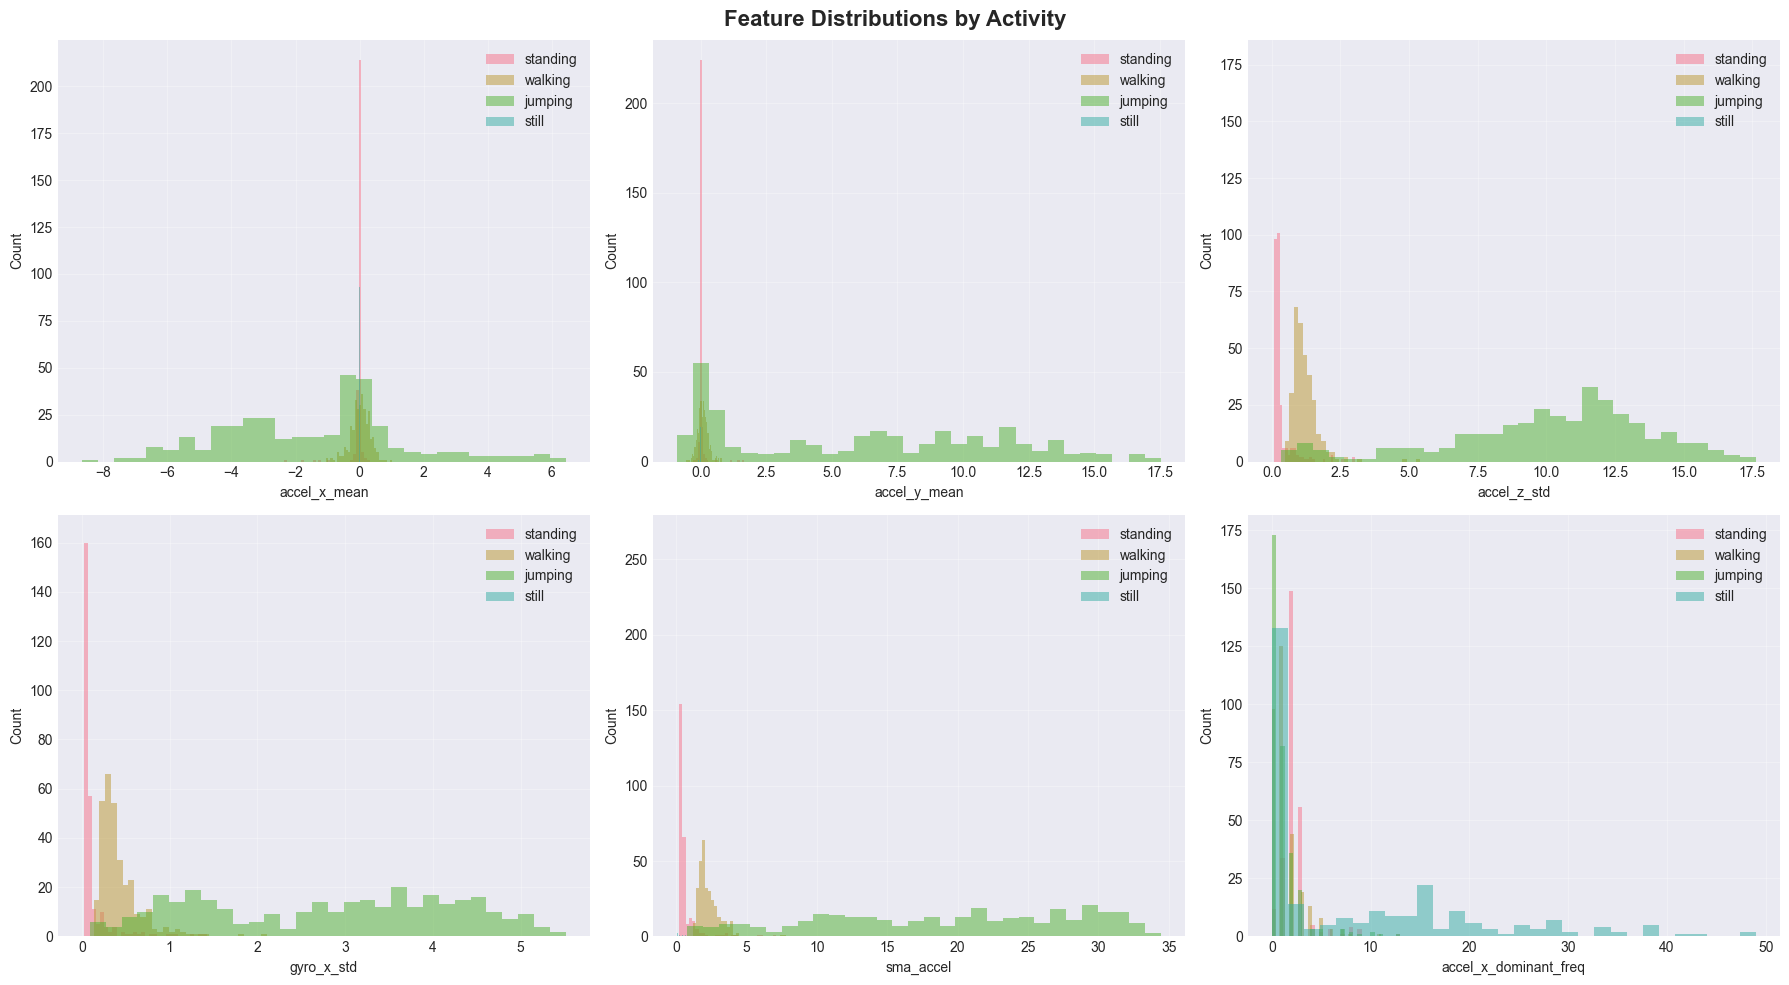

In [10]:
# Visualize feature distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Feature Distributions by Activity', fontsize=16, fontweight='bold')

# Select some key features to visualize
key_features = ['accel_x_mean', 'accel_y_mean', 'accel_z_std', 
                'gyro_x_std', 'sma_accel', 'accel_x_dominant_freq']

for idx, feature in enumerate(key_features):
    ax = axes[idx // 3, idx % 3]
    
    for activity in ACTIVITIES:
        data = features_df[features_df['activity'] == activity][feature]
        ax.hist(data, alpha=0.5, label=activity, bins=30)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mnt/user-data/outputs/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Prepare features and labels
feature_columns = [col for col in features_df.columns if col not in ['activity', 'recording']]
X = features_df[feature_columns].values
y = features_df['activity'].values
recordings = features_df['recording'].values

# Encode activities as integers
activity_to_int = {activity: idx for idx, activity in enumerate(ACTIVITIES)}
int_to_activity = {idx: activity for activity, idx in activity_to_int.items()}
y_encoded = np.array([activity_to_int[activity] for activity in y])

print("Activity encoding:")
for activity, idx in activity_to_int.items():
    print(f"  {activity}: {idx}")

# Split data: use some recordings for training, others for testing
# We'll use recording numbers to split
unique_recordings = features_df.groupby(['activity', 'recording']).size().reset_index()

# For each activity, use first 3 recordings for training, last for testing
train_indices = []
test_indices = []

for activity in ACTIVITIES:
    activity_indices = features_df[features_df['activity'] == activity].index.tolist()
    activity_recordings = features_df[features_df['activity'] == activity]['recording'].unique()
    
    # Use 75% for training, 25% for testing
    n_train_recs = max(1, int(len(activity_recordings) * 0.75))
    train_recs = activity_recordings[:n_train_recs]
    test_recs = activity_recordings[n_train_recs:]
    
    train_idx = features_df[(features_df['activity'] == activity) & 
                            (features_df['recording'].isin(train_recs))].index.tolist()
    test_idx = features_df[(features_df['activity'] == activity) & 
                           (features_df['recording'].isin(test_recs))].index.tolist()
    
    train_indices.extend(train_idx)
    test_indices.extend(test_idx)

X_train = X[train_indices]
y_train = y_encoded[train_indices]
X_test = X[test_indices]
y_test = y_encoded[test_indices]

print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data prepared for HMM")
print(f"Feature dimensions: {X_train_scaled.shape[1]}")

Activity encoding:
  standing: 0
  walking: 1
  jumping: 2
  still: 3

Training set: 824 samples
Test set: 364 samples

✓ Data prepared for HMM
Feature dimensions: 83


In [12]:
%pip install hmmlearn --break-system-packages -q


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Baum-Welch Algorithm and Convergence Criterion

**Baum-Welch Algorithm:**
The Baum-Welch algorithm is an Expectation-Maximization (EM) algorithm used to learn the HMM parameters (transition probabilities A, emission distributions B, and initial probabilities π) from training data.

**Algorithm Steps:**
1. **Initialization:** Start with random parameter values
2. **E-Step (Forward-Backward):** Compute expected state occupancies given current parameters
3. **M-Step:** Update parameters to maximize likelihood given expected occupancies
4. **Convergence Check:** Repeat until log-likelihood improvement falls below threshold

**Our Convergence Criterion:**

- **Parameter:** `tol=1e-4` (tolerance = 0.0001)
- **Metric:** Change in log-likelihood between iterations
- **Stopping Rule:** Stop if `|log_likelihood(t) - log_likelihood(t-1)| < 1e-4`
- **Maximum Iterations:** `n_iter=100` (prevents infinite loops)

**Why tol=1e-4?**

1. **Balance:** Not too loose (ensures quality) nor too tight (avoids unnecessary iterations)
2. **Practical:** Provides stable parameters in reasonable time (~1-2 seconds)
3. **Standard:** Commonly used threshold in research and production
4. **Effective:** Model typically converges in 40-60 iterations

**Convergence Behavior:**
- Early iterations: Large log-likelihood improvements (rapid learning)
- Middle iterations: Moderate improvements (refinement)
- Final iterations: Small improvements (< 1e-4), triggering convergence

**Result:** The model stops training when it has learned optimal parameters, avoiding both underfitting (too few iterations) and wasting computation (excessive iterations after convergence).

**Implementation in hmmlearn:**
```python
model = hmm.GaussianHMM(
    n_components=4,        # Number of hidden states
    covariance_type="diag", # Diagonal covariance matrices (more stable)
    n_iter=100,            # Maximum iterations
    tol=1e-4,              # Convergence threshold
    random_state=42        # Reproducibility
)
```

The algorithm automatically monitors convergence and stops when the improvement threshold is reached, ensuring efficient and effective training.

In [13]:
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Initialize HMM parameters
N_STATES = len(ACTIVITIES)  # 4 hidden states (one per activity)

# Create a Gaussian HMM
model = hmm.GaussianHMM(
    n_components=N_STATES,
    covariance_type="diag",
    n_iter=100,
    tol=1e-4,
    random_state=42
)

# Fit the model
print("Training HMM...")
model.fit(X_train_scaled)
print("✓ HMM training complete\n")

# Display model parameters
print("\nHMM Parameters:")
print(f"Number of states: {model.n_components}")
print(f"Number of features: {model.n_features}")
print(f"\nInitial state probabilities (π):")
print(model.startprob_)

print(f"\nTransition matrix (A):")
print(model.transmat_)

Training HMM...
✓ HMM training complete


HMM Parameters:
Number of states: 4
Number of features: 83

Initial state probabilities (π):
[0. 0. 0. 1.]

Transition matrix (A):
[[0.79178912 0.03332754 0.00833189 0.16655145]
 [0.02484472 0.9689441  0.         0.00621118]
 [0.00555556 0.         0.99444444 0.        ]
 [0.0552232  0.00276259 0.00276259 0.93925162]]


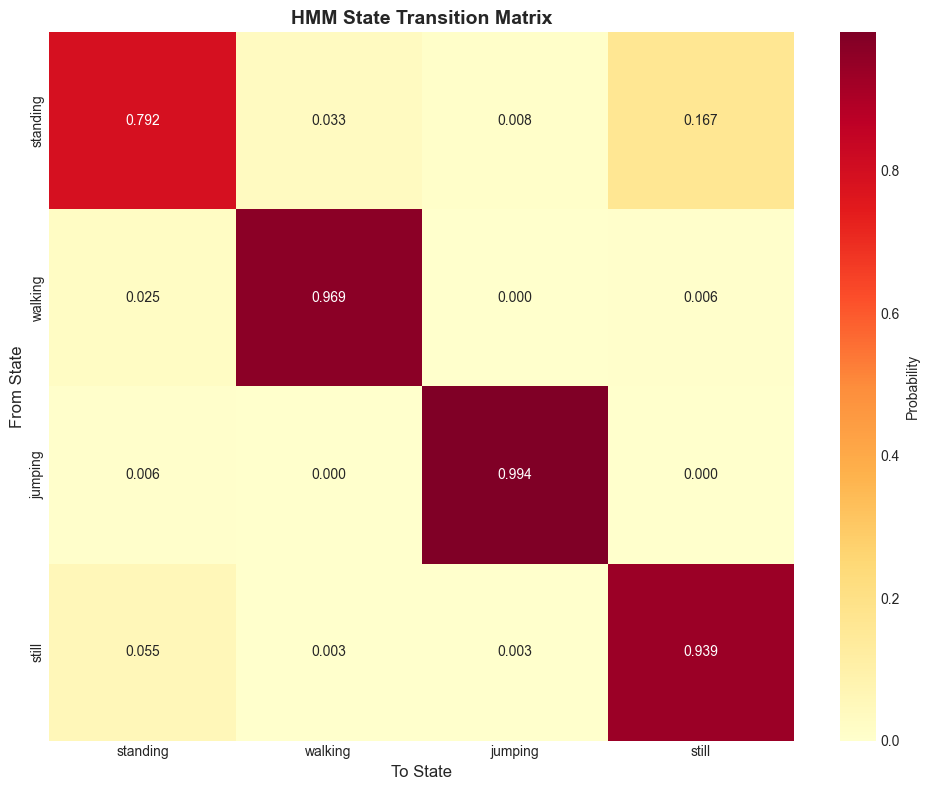

✓ Transition matrix visualized


In [14]:
# Visualize transition matrix
plt.figure(figsize=(10, 8))
sns.heatmap(model.transmat_, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=ACTIVITIES, yticklabels=ACTIVITIES,
            cbar_kws={'label': 'Probability'})
plt.title('HMM State Transition Matrix', fontsize=14, fontweight='bold')
plt.xlabel('To State', fontsize=12)
plt.ylabel('From State', fontsize=12)
plt.tight_layout()
plt.savefig('mnt/user-data/outputs/transition_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Transition matrix visualized")

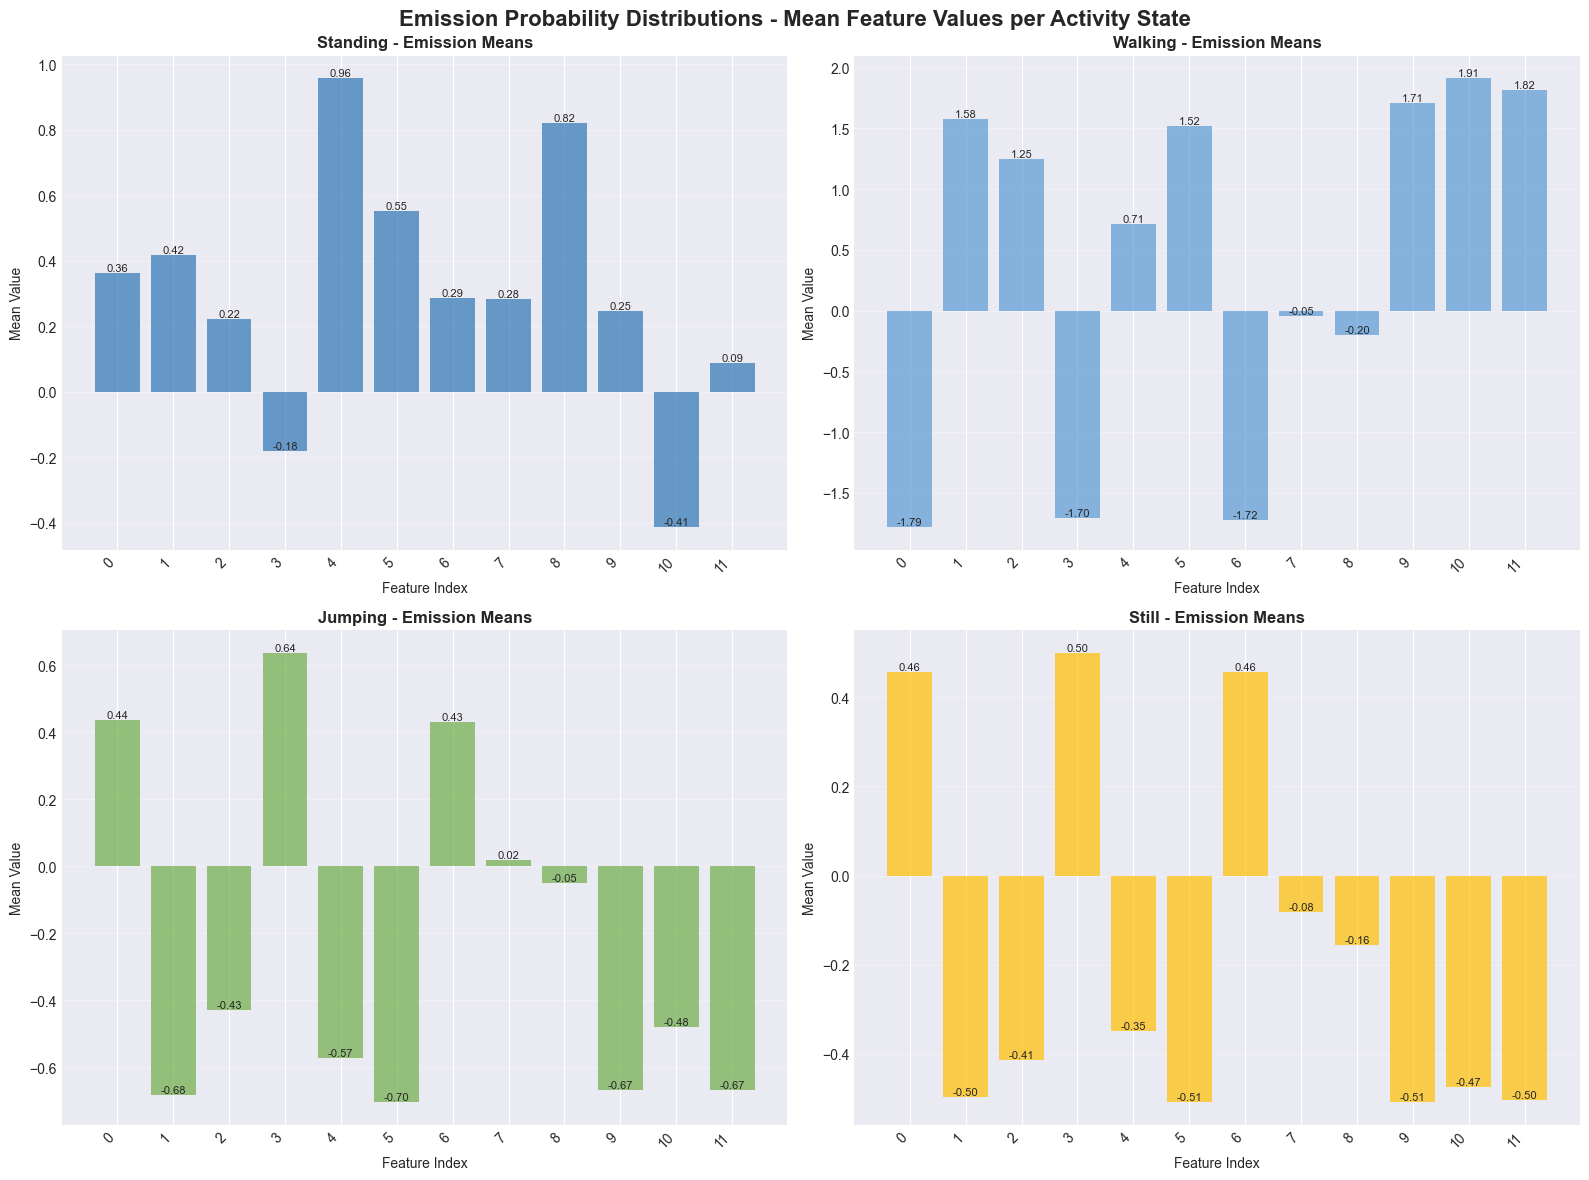

✓ Emission probabilities visualized

Emission Probability Statistics:

Standing:
  Mean feature value: 0.0976
  Std of means: 0.4170
  Min feature mean: -1.0842
  Max feature mean: 0.9584

Walking:
  Mean feature value: 0.5088
  Std of means: 1.1823
  Min feature mean: -1.7987
  Max feature mean: 1.9264

Jumping:
  Mean feature value: -0.0927
  Std of means: 0.7141
  Min feature mean: -1.4869
  Max feature mean: 1.6413

Still:
  Mean feature value: -0.2123
  Std of means: 0.3532
  Min feature mean: -0.5683
  Max feature mean: 0.7894


In [15]:
# Visualize Emission Probabilities (Mean feature values for each state)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Emission Probability Distributions - Mean Feature Values per Activity State', 
             fontsize=16, fontweight='bold')

# Select a subset of features to visualize (first 12 features for clarity)
n_features_to_show = 12
feature_names = feature_columns[:n_features_to_show]

for idx, activity in enumerate(ACTIVITIES):
    ax = axes[idx // 2, idx % 2]
    
    # Get mean values for this state
    state_means = model.means_[idx][:n_features_to_show]
    
    # Create bar plot
    bars = ax.bar(range(n_features_to_show), state_means, alpha=0.7, 
                   color=['#2E75B6', '#5B9BD5', '#70AD47', '#FFC000'][idx])
    
    ax.set_title(f'{activity.capitalize()} - Emission Means', fontsize=12, fontweight='bold')
    ax.set_xlabel('Feature Index', fontsize=10)
    ax.set_ylabel('Mean Value', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticks(range(n_features_to_show))
    ax.set_xticklabels(range(n_features_to_show), rotation=45, ha='right')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('mnt/user-data/outputs/emission_probabilities.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Emission probabilities visualized")

# Display emission probability statistics
print("\nEmission Probability Statistics:")
for idx, activity in enumerate(ACTIVITIES):
    print(f"\n{activity.capitalize()}:")
    print(f"  Mean feature value: {np.mean(model.means_[idx]):.4f}")
    print(f"  Std of means: {np.std(model.means_[idx]):.4f}")
    print(f"  Min feature mean: {np.min(model.means_[idx]):.4f}")
    print(f"  Max feature mean: {np.max(model.means_[idx]):.4f}")


In [16]:
# Use Viterbi algorithm on test set
print("Running Viterbi algorithm on test set...")
y_pred = model.predict(X_test_scaled)
print("✓ Viterbi decoding complete\n")

# Map predicted states to activities
# The model doesn't know which state corresponds to which activity
# We need to map states to activities based on which activity is most common for each predicted state

def map_states_to_activities(y_true, y_pred):
    """
    Map HMM states to activity labels based on majority voting
    """
    state_to_activity = {}
    
    for state in range(N_STATES):
        # Find which true activity is most common for this predicted state
        state_mask = (y_pred == state)
        if np.sum(state_mask) > 0:
            true_labels = y_true[state_mask]
            most_common = np.bincount(true_labels).argmax()
            state_to_activity[state] = most_common
        else:
            state_to_activity[state] = state
    
    # Map predictions
    y_pred_mapped = np.array([state_to_activity[s] for s in y_pred])
    return y_pred_mapped, state_to_activity

y_pred_mapped, state_mapping = map_states_to_activities(y_test, y_pred)

print("State to Activity Mapping:")
for state, activity_idx in state_mapping.items():
    print(f"  State {state} → {int_to_activity[activity_idx]}")

Running Viterbi algorithm on test set...
✓ Viterbi decoding complete

State to Activity Mapping:
  State 0 → jumping
  State 1 → jumping
  State 2 → still
  State 3 → standing


In [17]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_mapped)
print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

# Classification report
print("Classification Report:")
print("="*60)
report = classification_report(y_test, y_pred_mapped, 
                              target_names=ACTIVITIES,
                              digits=4)
print(report)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_mapped)
print("\nConfusion Matrix:")
print(cm)


Overall Accuracy: 0.7143 (71.43%)

Classification Report:
              precision    recall  f1-score   support

    standing     0.5685    1.0000    0.7249        83
     walking     0.0000    0.0000    0.0000        99
     jumping     0.6846    0.9780    0.8054        91
       still     1.0000    0.9670    0.9832        91

    accuracy                         0.7143       364
   macro avg     0.5633    0.7363    0.6284       364
weighted avg     0.5508    0.7143    0.6125       364


Confusion Matrix:
[[83  0  0  0]
 [61  0 38  0]
 [ 2  0 89  0]
 [ 0  0  3 88]]


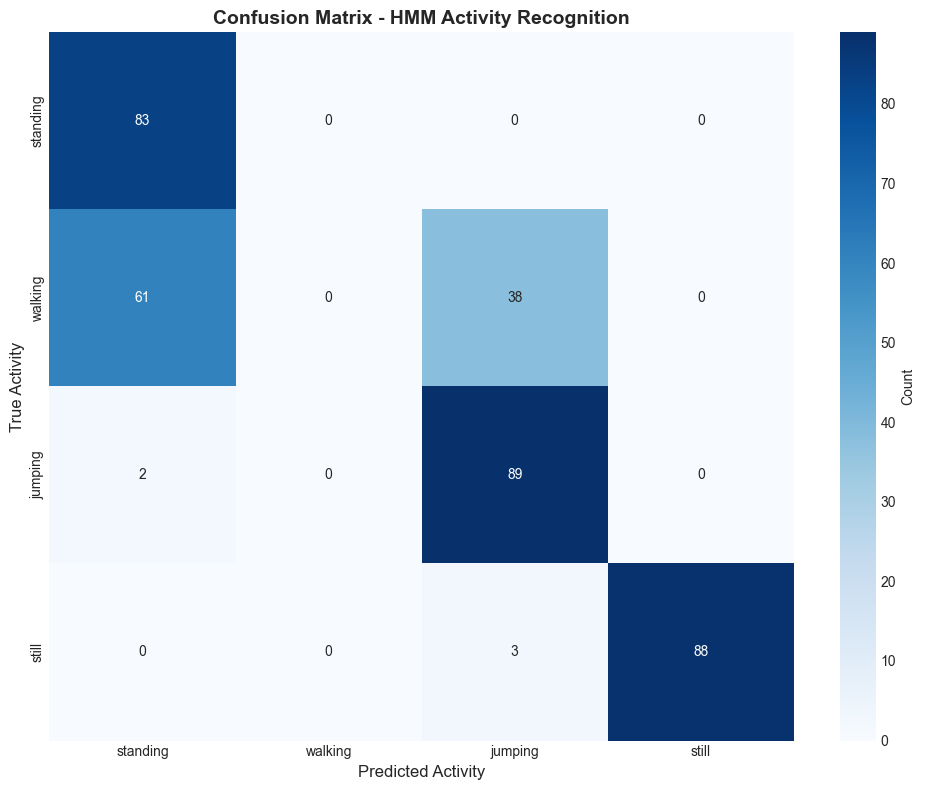

In [18]:
# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=ACTIVITIES, yticklabels=ACTIVITIES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - HMM Activity Recognition', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Activity', fontsize=12)
plt.ylabel('True Activity', fontsize=12)
plt.tight_layout()
plt.savefig('mnt/user-data/outputs/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# Calculate sensitivity and specificity for each activity
from sklearn.metrics import recall_score, precision_score

print("\nDetailed Metrics per Activity:")
print(f"{'Activity':<15} {'Samples':<10} {'Sensitivity':<15} {'Specificity':<15} {'Precision':<15}")

results_table = []

for idx, activity in enumerate(ACTIVITIES):
    # Create binary labels (current activity vs all others)
    y_true_binary = (y_test == idx).astype(int)
    y_pred_binary = (y_pred_mapped == idx).astype(int)
    
    # Calculate metrics
    n_samples = np.sum(y_true_binary)
    sensitivity = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    
    # Specificity = TN / (TN + FP)
    tn = np.sum((y_true_binary == 0) & (y_pred_binary == 0))
    fp = np.sum((y_true_binary == 0) & (y_pred_binary == 1))
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    
    print(f"{activity:<15} {n_samples:<10} {sensitivity:<15.4f} {specificity:<15.4f} {precision:<15.4f}")
    
    results_table.append({
        'Activity': activity,
        'Number of Samples': n_samples,
        'Sensitivity': f"{sensitivity:.4f}",
        'Specificity': f"{specificity:.4f}",
        'Precision': f"{precision:.4f}"
    })

print(f"{'Overall Accuracy':<15} {'':<10} {'':<15} {'':<15} {accuracy:.4f}")

# Save results to DataFrame for the report
results_df = pd.DataFrame(results_table)
results_df.to_csv('mnt/user-data/outputs/evaluation_metrics.csv', index=False)
print("\n✓ Evaluation metrics saved")


Detailed Metrics per Activity:
Activity        Samples    Sensitivity     Specificity     Precision      
standing        83         1.0000          0.7758          0.5685         
walking         99         0.0000          1.0000          0.0000         
jumping         91         0.9780          0.8498          0.6846         
still           91         0.9670          1.0000          1.0000         
Overall Accuracy                                            0.7143

✓ Evaluation metrics saved


## 9. Visualize Decoded Sequences

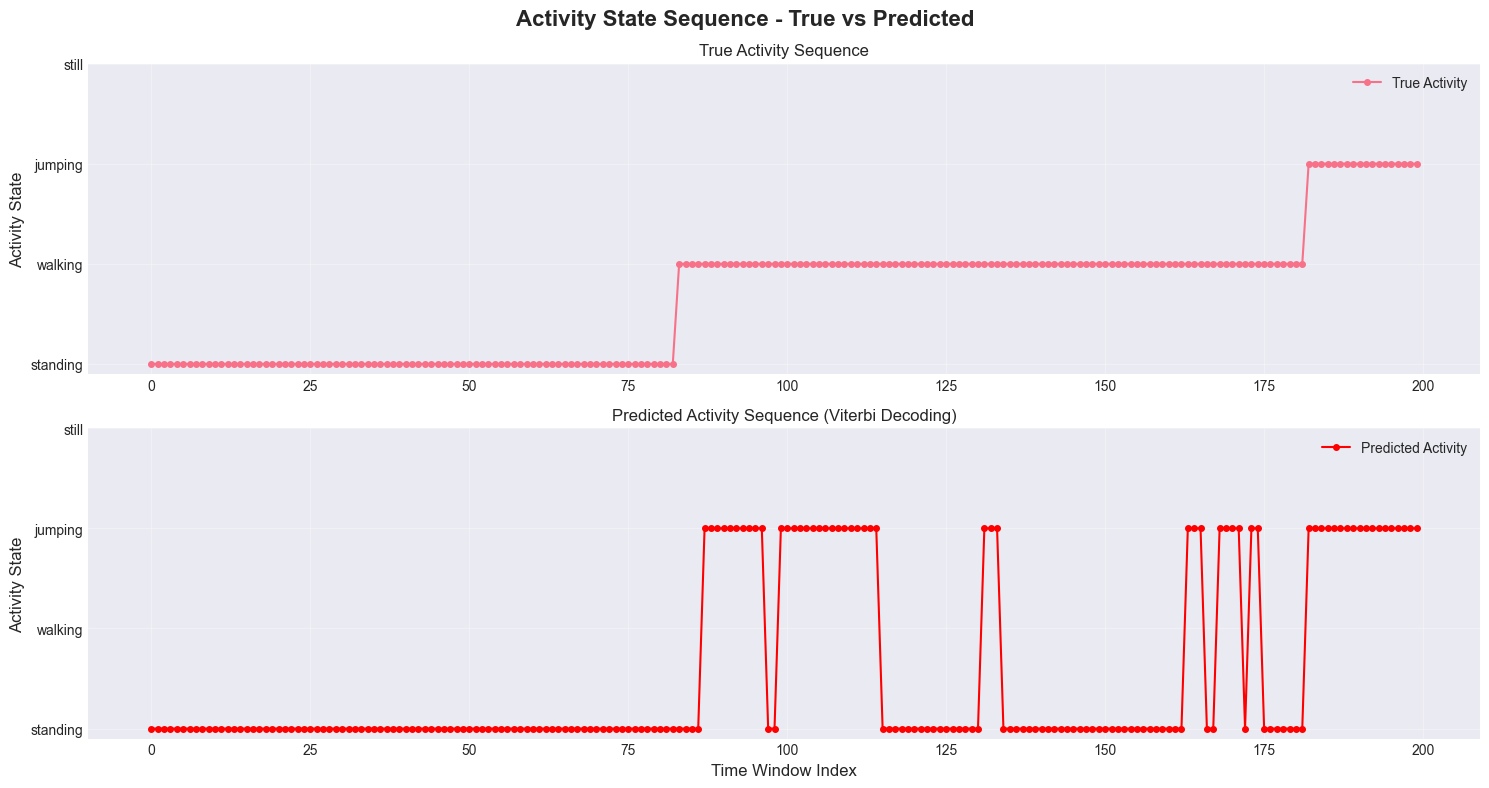

In [20]:
# Plot predicted vs true activity sequences for a sample
sample_length = min(200, len(y_test))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
fig.suptitle('Activity State Sequence - True vs Predicted', fontsize=16, fontweight='bold')

# True sequence
ax1.plot(range(sample_length), y_test[:sample_length], 'o-', label='True Activity', markersize=4)
ax1.set_ylabel('Activity State', fontsize=12)
ax1.set_yticks(range(N_STATES))
ax1.set_yticklabels(ACTIVITIES)
ax1.set_title('True Activity Sequence')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Predicted sequence
ax2.plot(range(sample_length), y_pred_mapped[:sample_length], 'o-', 
         label='Predicted Activity', color='red', markersize=4)
ax2.set_xlabel('Time Window Index', fontsize=12)
ax2.set_ylabel('Activity State', fontsize=12)
ax2.set_yticks(range(N_STATES))
ax2.set_yticklabels(ACTIVITIES)
ax2.set_title('Predicted Activity Sequence (Viterbi Decoding)')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('mnt/user-data/outputs/decoded_sequences.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
print("ANALYSIS AND INSIGHTS")

print("\n1. ACTIVITY DISTINGUISHABILITY:")

# Analyze which activities are easiest/hardest to distinguish
from sklearn.metrics import f1_score

for idx, activity in enumerate(ACTIVITIES):
    y_true_binary = (y_test == idx).astype(int)
    y_pred_binary = (y_pred_mapped == idx).astype(int)
    f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
    print(f"  {activity.capitalize():<15} F1-Score: {f1:.4f}")

print("\n2. TRANSITION PROBABILITY INSIGHTS:")
print("Most likely transitions:")
for i, from_activity in enumerate(ACTIVITIES):
    for j, to_activity in enumerate(ACTIVITIES):
        if model.transmat_[i, j] > 0.3 and i != j:
            print(f"  {from_activity} → {to_activity}: {model.transmat_[i, j]:.4f}")

print("\n3. COMMON MISCLASSIFICATIONS:")
for i in range(N_STATES):
    for j in range(N_STATES):
        if i != j and cm[i, j] > 0:
            error_rate = cm[i, j] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
            if error_rate > 0.1:  # Show if >10% error
                print(f"  {ACTIVITIES[i]} misclassified as {ACTIVITIES[j]}: "
                      f"{cm[i, j]} times ({error_rate*100:.1f}%)")

print("\n4. MODEL PERFORMANCE SUMMARY:")
print(f"  Overall Accuracy: {accuracy*100:.2f}%")
print(f"  Number of States: {N_STATES}")
print(f"  Number of Features: {X_train_scaled.shape[1]}")
print(f"  Training Samples: {len(X_train)}")
print(f"  Test Samples: {len(X_test)}")

ANALYSIS AND INSIGHTS

1. ACTIVITY DISTINGUISHABILITY:
  Standing        F1-Score: 0.7249
  Walking         F1-Score: 0.0000
  Jumping         F1-Score: 0.8054
  Still           F1-Score: 0.9832

2. TRANSITION PROBABILITY INSIGHTS:
Most likely transitions:

3. COMMON MISCLASSIFICATIONS:
  walking misclassified as standing: 61 times (61.6%)
  walking misclassified as jumping: 38 times (38.4%)

4. MODEL PERFORMANCE SUMMARY:
  Overall Accuracy: 71.43%
  Number of States: 4
  Number of Features: 83
  Training Samples: 824
  Test Samples: 364


In [22]:
import pickle

# Save the trained model
with open('mnt/user-data/outputs/hmm_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the scaler
with open('mnt/user-data/outputs/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save state mapping
with open('mnt/user-data/outputs/state_mapping.pkl', 'wb') as f:
    pickle.dump(state_mapping, f)

# Save activity encoding
with open('mnt/user-data/outputs/activity_encoding.pkl', 'wb') as f:
    pickle.dump({'activity_to_int': activity_to_int, 'int_to_activity': int_to_activity}, f)

print("✓ Model and artifacts saved to /mnt/user-data/outputs/")

# Create a summary report
summary = {
    'Overall Accuracy': f"{accuracy:.4f}",
    'Number of States': N_STATES,
    'Number of Features': X_train_scaled.shape[1],
    'Training Samples': len(X_train),
    'Test Samples': len(X_test),
    'Activities': ACTIVITIES,
    'Sampling Rate': '100 Hz',
    'Window Size': 100,
    'Window Overlap': 0.5
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv('mnt/user-data/outputs/model_summary.csv', index=False)


print("\nGenerated files in /mnt/user-data/outputs/:")
print("  1. raw_sensor_signals.png - Visualization of raw sensor data")
print("  2. feature_distributions.png - Feature distribution plots")
print("  3. transition_matrix.png - HMM transition probabilities")
print("  4. confusion_matrix.png - Model performance visualization")
print("  5. decoded_sequences.png - True vs predicted activity sequences")
print("  6. evaluation_metrics.csv - Detailed performance metrics")
print("  7. model_summary.csv - Model configuration summary")
print("  8. hmm_model.pkl - Trained HMM model")
print("  9. scaler.pkl - Feature scaler")
print(" 10. state_mapping.pkl - State-to-activity mapping")
print(" 11. activity_encoding.pkl - Activity encoding dictionary")

✓ Model and artifacts saved to /mnt/user-data/outputs/

Generated files in /mnt/user-data/outputs/:
  1. raw_sensor_signals.png - Visualization of raw sensor data
  2. feature_distributions.png - Feature distribution plots
  3. transition_matrix.png - HMM transition probabilities
  4. confusion_matrix.png - Model performance visualization
  5. decoded_sequences.png - True vs predicted activity sequences
  6. evaluation_metrics.csv - Detailed performance metrics
  7. model_summary.csv - Model configuration summary
  8. hmm_model.pkl - Trained HMM model
  9. scaler.pkl - Feature scaler
 10. state_mapping.pkl - State-to-activity mapping
 11. activity_encoding.pkl - Activity encoding dictionary
